# Project Description

# Summary of Data

# Data Exploration and Preprocessing

In [1]:
### Data Manipulation Imports ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import pandas as pd

In [ ]:
### Show Data Frame ###

df.head()

In [ ]:
### Data Cleaning ###

In [ ]:
### Remove Trend ###

In [ ]:
### Show Data ###

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.scatter(df.Date,df.total_num_trips)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
plt.gcf().autofmt_xdate()

ax.set_xlabel('Date')
ax.set_ylabel('Number of Trips')
ax.set_title('Number of Trips Over Time')

plt.show()

In [2]:
bike_train = pd.read_csv('../EDA/bikeshare_train_data_pcwsdetrend_mult.csv', parse_dates = ['Date'])
bike_test = pd.read_csv('../EDA/bikeshare_test_data_pcwsdetrend_mult.csv', parse_dates = ['Date'])

# Baseline Models

In [7]:
### Modeling Imports ###

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

### Regression Models

In ``EDA.ipynb`` we used correlation matrices, plots, and lasso regression to perform some feature selection and handle some collinearity issues between columns. As such the features we will focus on for regression models are
- ``day_length``,
- ``max_temp``,
- ``temp_diff``,
- ``total_precip``,
- ``snow_on_ground``, and
- ``max_gust``.

We'll use the best regression model as one of our baseline models.

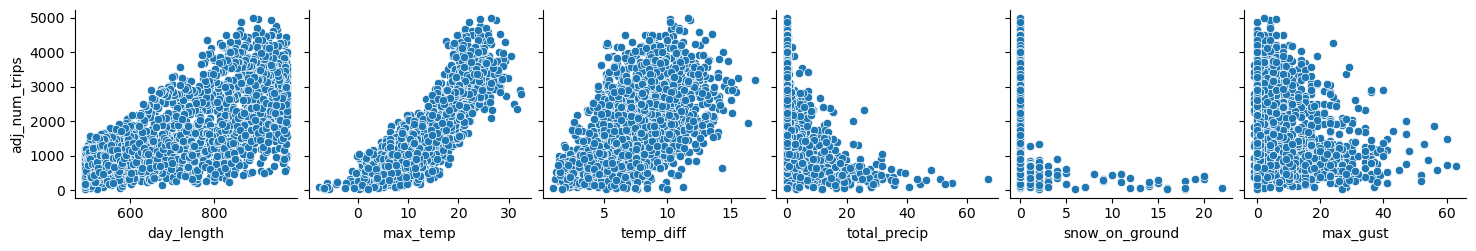

In [4]:
features = ['day_length','max_temp','temp_diff','total_precip','snow_on_ground','max_gust']
##Target variable name, this should be a column of the bikeshare-weather data csv that has a version of detrending applied to it
target = 'adj_num_trips'
sns.pairplot(data=bike_train,
             x_vars=features,
            y_vars=[target])

plt.show()

Some initial thoughts:
- ``max_temp`` probably depends on ``day_length`` in some way so we should probably include an interaction term for these two features,
- Much of ``snow_on_ground`` is zero (and when nonzero has a pretty "small" distribution of values) so including or excluding this term in a model likely won't affect performance much, and
- ``max_gust`` and ``temp_diff`` look too scattered that it's possible they don't make it into the final model.

In any case, we only have six features under consideration. We can perform best subsets selection on these six features and then if some of the higher-performing subsets include ``day_length`` and ``max_temp`` we can compare those models' performances to one including an interaction term (we could do this in the other order--i.e., including the interaction, doing best subsets selection, then throwing away models that include the interaction term but not both the others, but our way has a shorter runtime).

In [5]:
# This returns the power set of a set minus the empty set. (Copied from a lecture notebook from this bootcamp)
# Credit to Erdős alumni Nadir Hajouji for greatly simplifying this function!

def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

In [8]:
n_splits = 5
kfold = KFold(n_splits,
              shuffle=True,
              random_state=604)

In [9]:
scaler = StandardScaler().set_output(transform='pandas')
bike_train_scaled = scaler.fit_transform(bike_train[features])
bike_train_scaled[target] = bike_train[target]

In [10]:
models = powerset(features)
rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bike_train_scaled)):
    bike_tt = bike_train_scaled.iloc[train_index]
    bike_ho = bike_train_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

In [11]:
avg_rmses = np.mean(rmses, axis=0)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

The models have average cross-validation RMSEs ranging from 465.1681680110137 to 1063.9025986271474
The model with the minimum average cross-validation RMSE of 465.1681680110137 uses the features ['day_length', 'max_temp', 'temp_diff', 'total_precip', 'snow_on_ground', 'max_gust']


That's all the features (although we can see that there are certain other models that also perform similarly that use subsets of these features). Let's compare this performance to best subsets where all models include ``day_length``, ``max_temp``, and an interaction term between them:

In [13]:
bike_train_scaled['day_length_x_max_temp'] = bike_train_scaled.day_length * bike_train_scaled.max_temp

base_features = ['day_length','max_temp','day_length_x_max_temp']
remaining_features = ['temp_diff', 'total_precip', 'snow_on_ground', 'max_gust']
models = [base_features + subset for subset in powerset(remaining_features)]

rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bike_train_scaled)):
    bike_tt = bike_train_scaled.iloc[train_index]
    bike_ho = bike_train_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

avg_rmses = np.mean(rmses,axis=0)

print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

The models have average cross-validation RMSEs ranging from 456.58861825895553 to 530.7206089386095
The model with the minimum average cross-validation RMSE of 456.58861825895553 uses the features ['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']


In [14]:
best_subset = models[np.argmin(avg_rmses)]

reg_bestsubset = LinearRegression()
reg_bestsubset.fit(bike_train_scaled[best_subset],
                   bike_train[target])
preds_bestsubset = reg_bestsubset.predict(bike_train_scaled[best_subset])

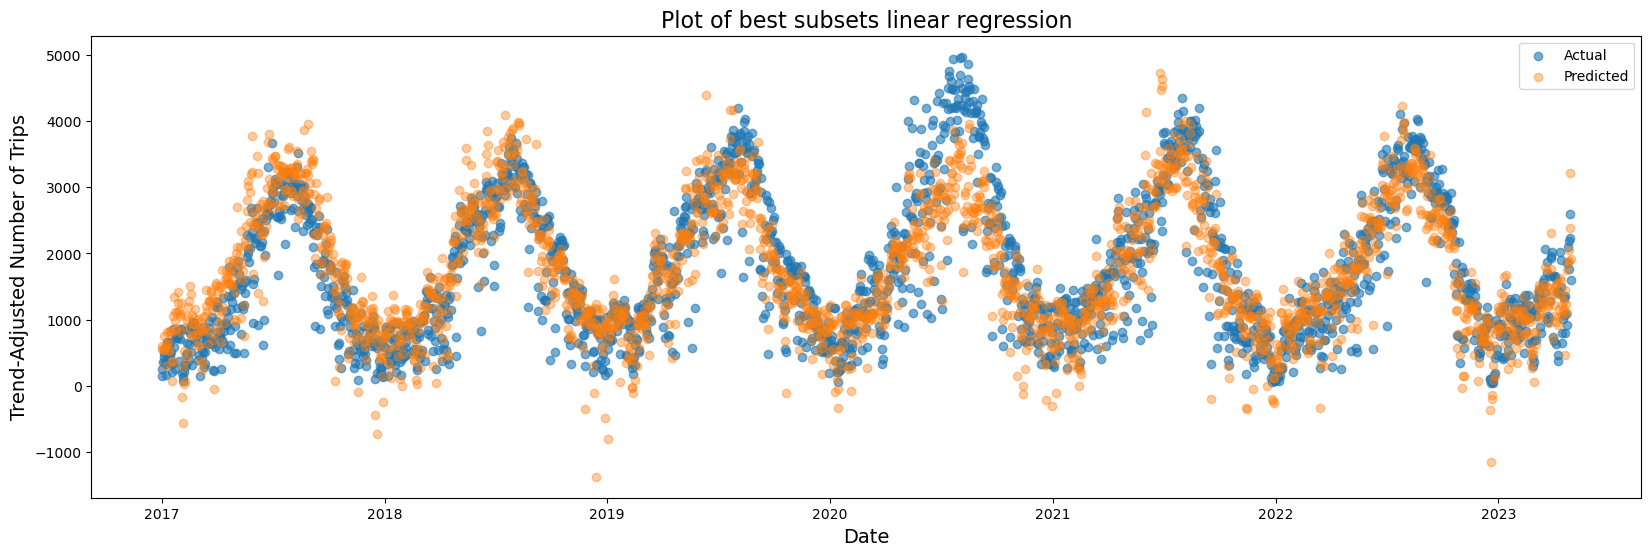

In [25]:
plt.figure(figsize=(20,6))

plt.scatter(bike_train.Date,
           bike_train[target],
           alpha=0.6,
           label='Actual')

plt.scatter(bike_train.Date,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Trend-Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression',fontsize=16)
plt.legend()

plt.show()

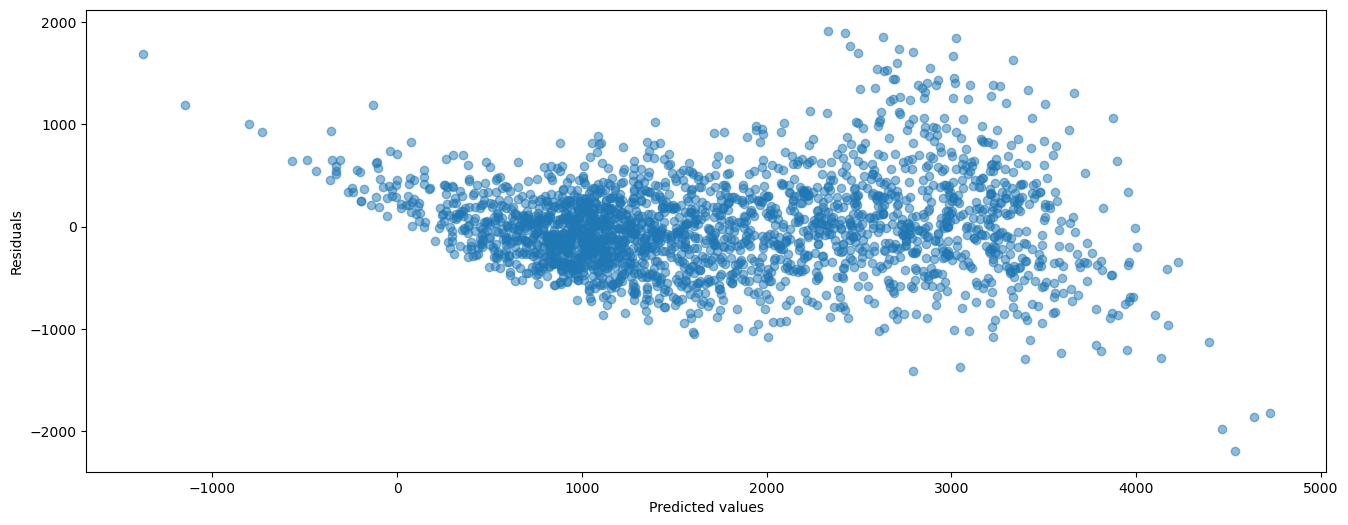

In [16]:
residuals = bike_train[target] - preds_bestsubset

plt.figure(figsize=(16,6))

plt.scatter(preds_bestsubset,
           residuals,
           alpha=0.5)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.show()

As we can see, a lot of our error is concentrated in mid-2020. One can verify (e.g., see `regressions.ipynb`) that weather patterns from mid-2020 are not much different than other years, so this error is due to either factors unseen by the data or an inaccuracy in our trend forecasting (likely the latter).

We can also see that the residuals grow as the predicted value grows. Note that most of the predicted values around 3000 occur during summer months, and summer 2020 contains our largest residuals.

### Regression performance on test data

In [20]:
bike_test_scaled = scaler.transform(bike_test[features])
bike_test_scaled[target] = bike_test[target]

bike_test_scaled['day_length_x_max_temp'] = bike_test_scaled.day_length * bike_test_scaled.max_temp

test_preds = reg_bestsubset.predict(bike_test_scaled[best_subset])

pred_num_trips_train = preds_bestsubset * bike_train['trend_val']
pred_num_trips_test = test_preds * bike_test['trend_val']

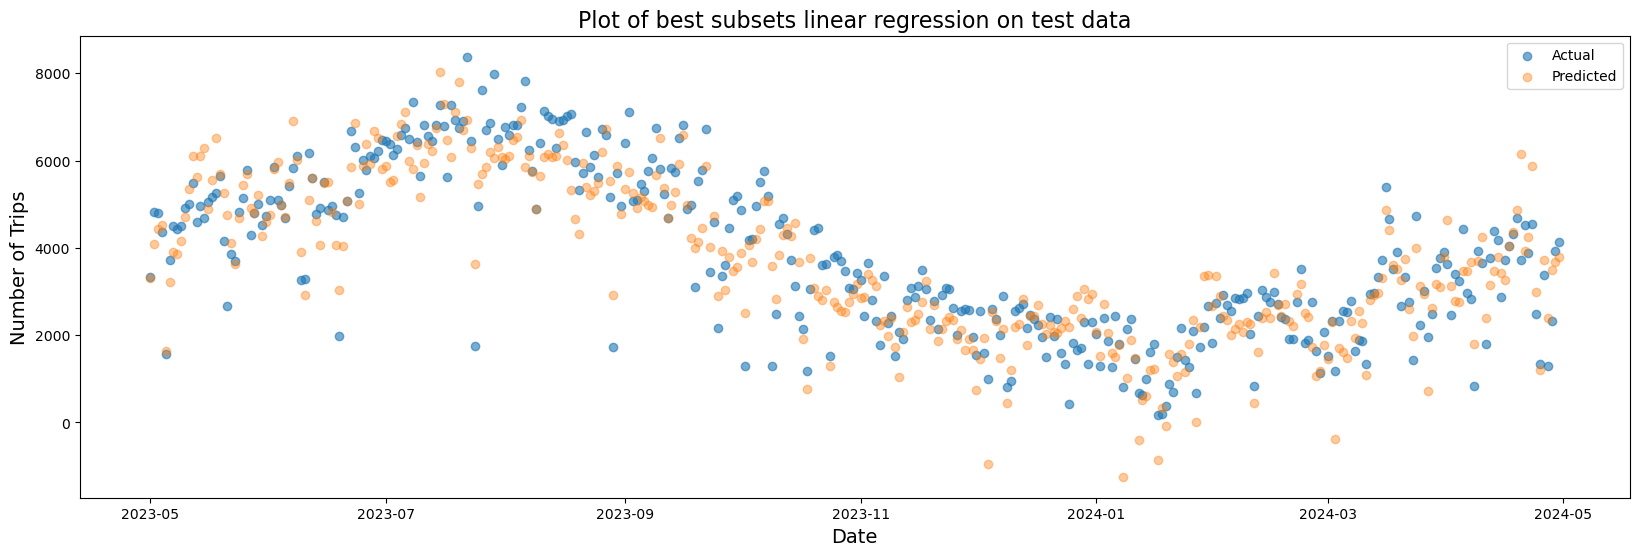

In [26]:
plt.figure(figsize=(20,6))

plt.scatter(bike_test.Date,
           bike_test.num_trips,
           alpha=0.6,
           label='Actual')

plt.scatter(bike_test.Date,
           pred_num_trips_test,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on test data',fontsize=16)
plt.legend()

plt.show()

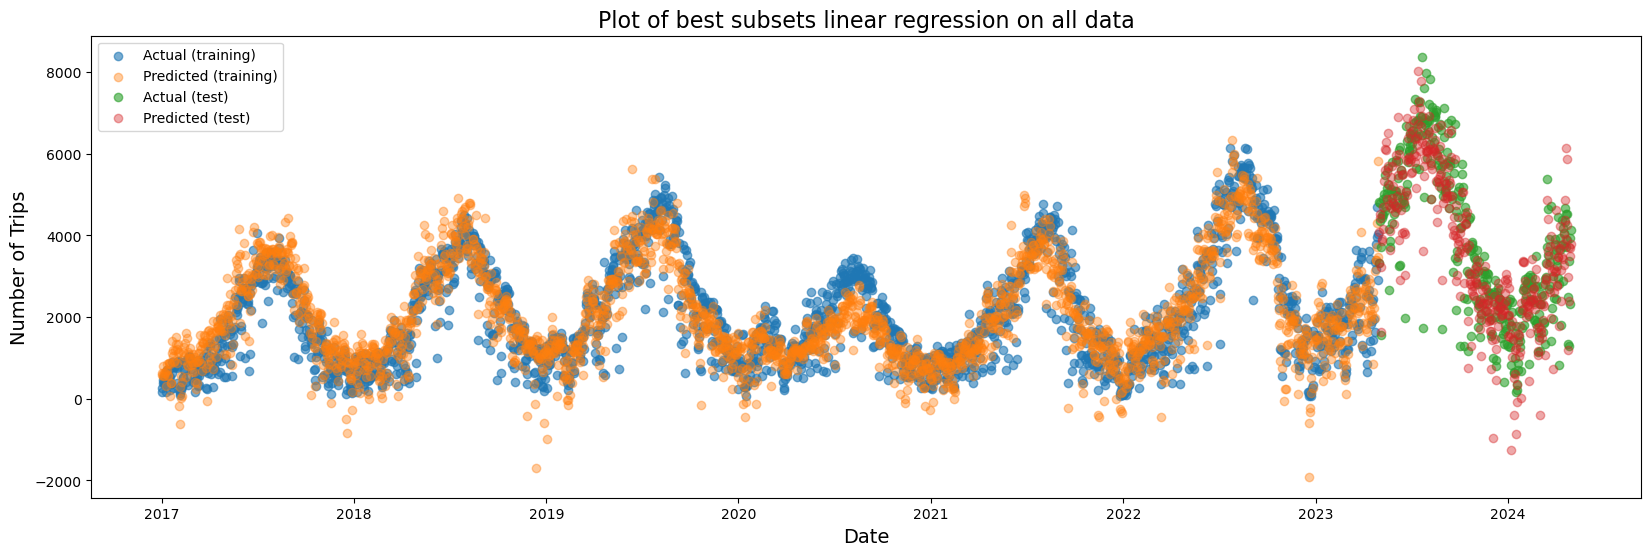

In [27]:
plt.figure(figsize=(20,6))

plt.scatter(bike_train.Date,
           bike_train.num_trips,
           alpha=0.6,
           label='Actual (training)')

plt.scatter(bike_train.Date,
           pred_num_trips_train,
           alpha=0.4,
           label='Predicted (training)')

plt.scatter(bike_test.Date,
           bike_test.num_trips,
           alpha=0.6,
           label='Actual (test)')

plt.scatter(bike_test.Date,
           pred_num_trips_test,
           alpha=0.4,
           label='Predicted (test)')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on all data',fontsize=16)
plt.legend()

plt.show()

In [29]:
# Calculate RMSEs

train_rmse = np.sqrt(mean_squared_error(bike_train.num_trips,pred_num_trips_train))
test_rmse = np.sqrt(mean_squared_error(bike_test.num_trips,pred_num_trips_test))
print("The RMSE for predicting num_trips on the training data is",train_rmse)
print("The RMSE for predicting num_trips on the test data is",test_rmse)

The RMSE for predicting num_trips on the training data is 495.408536695072
The RMSE for predicting num_trips on the test data is 730.799700085758


### Basic KNN Model

#### KNR on dates

In [ ]:
# Add column for day of the year
bike_train['DoY'] = bike_train['Date'].apply(lambda x : x.day_of_year)
bike_test['DoY'] = bike_test['Date'].apply(lambda x : x.day_of_year)

# Define 'distance' to be used in kNN
def dist(x,y):
    return min([abs(x-y),365-abs(x-y)])

In [ ]:
# Build example model with k=5
model = KNeighborsRegressor(n_neighbors=5, metric=dist)
model.fit(X=bike_train[['DoY']], y=bike_train[['adj_num_trips']]);

In [ ]:
# Plot predictions on training data

y_train_pred = model.predict(X=bike_train[['DoY']])*bike_train[['trend_val']]

ax = plt.subplots(figsize=(12,6))[1]
ax.scatter(bike_train['Date'], bike_train['num_trips'], alpha=0.5, label='actual')
ax.scatter(bike_train['Date'], y_train_pred, alpha=0.5, c='r', label='predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Number of bike trips')
ax.legend(loc='upper left')
ax.set_title('kNN Predictions on Training Data (k=5)')
plt.show()

In [ ]:
# Cross-validate on training data to find optimal k

kfold = KFold(n_splits=5, random_state=50, shuffle=True)

k_vals = [j for j in range(1,10)] + [10*j for j in range(1,21)]

i=0
RMSE_train = np.zeros((5,len(k_vals)))
RMSE_test = np.zeros((5,len(k_vals)))

for train_index, test_index in kfold.split(bike_train):

    CV_train = bike_train.iloc[train_index]
    CV_test = bike_train.iloc[test_index]

    for j in range(len(k_vals)):
        model = KNeighborsRegressor(n_neighbors=k_vals[j], metric=dist)
        model.fit(X=CV_train[['DoY']], y=CV_train[['adj_num_trips']])

        pred_train = model.predict(X=CV_train[['DoY']])*CV_train[['trend_val']]
        RMSE_train[i,j] = np.sqrt(mean_squared_error(y_true=CV_train[['num_trips']], y_pred=pred_train))

        pred_test = model.predict(X=CV_test[['DoY']])*CV_test[['trend_val']]
        RMSE_test[i,j] = np.sqrt(mean_squared_error(y_true=CV_test[['num_trips']], y_pred=pred_test))

    i += 1

In [ ]:
average_RMSE_train= RMSE_train.mean(axis=0)
average_RMSE_test = RMSE_test.mean(axis=0)

In [ ]:
ax = plt.subplots(figsize=(12,6))[1]
ax.plot(k_vals[5:19], average_RMSE_train[5:19], label='training data')
ax.plot(k_vals[5:19], average_RMSE_test[5:19], c='r', label='test data')
ax.set_xlabel('k')
ax.set_ylabel('Average RMSE')
ax.set_title('kNN Cross-Validation (5 <= k <= 100)')
ax.legend(loc='upper right')
plt.show()

In [ ]:
ax = plt.subplots(figsize=(12,6))[1]
ax.plot(k_vals[18:], average_RMSE_train[18:], label='training data')
ax.plot(k_vals[18:], average_RMSE_test[18:], c='r', label='test data')
ax.set_xlabel('k')
ax.set_ylabel('Average RMSE')
ax.set_title('kNN Cross-Validation (100 <= k <= 200)')
ax.legend(loc='upper left')
plt.show()

In [ ]:
# Build final KNN model with k=60

model = KNeighborsRegressor(n_neighbors=60, metric=dist)
model.fit(X=bike_train[['DoY']], y=bike_train[['adj_num_trips']]);

In [ ]:
# Calculate train and test RMSEs

pred_train = model.predict(X=bike_train[['DoY']])*bike_train[['trend_val']]
RMSE_train = np.sqrt(mean_squared_error(y_true=bike_train[['num_trips']], y_pred=pred_train))
pred_test = model.predict(X=bike_test[['DoY']])*bike_test[['trend_val']]
RMSE_test = np.sqrt(mean_squared_error(y_true=bike_test[['num_trips']], y_pred=pred_test))

print('Training RMSE:', RMSE_train)
print('Test RMSE:', RMSE_test)

### KNR on weather features

#### A model comparison function

 The following function compares different modeling approaches

- The ``model`` argument takes a model object, e.g., LinearRegression, KNR
- The variable ``X_train`` depends on how we select the features 
- The variable ``y_train`` depends on how we detrend the data
- ``n`` is the number of cross-validations

The function returns the average root MSE over the validation sets, predicted values, and the residues.

In [ ]:
def test(model, X_train, y_train, n):
    
    kfold = KFold(n_splits = n, shuffle = True, random_state = 50)
    total_rmse = 0
    
    for train_index, test_index in kfold.split(X_train):
    
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
    
        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]
    
        ## Fit the model
        model.fit(X_tt,y_tt)

        # Make the prediction
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        total_rmse += rmse

    predict_values = model.predict(X_train)
    residues = y_train - model.predict(X_train)
    
    return total_rmse/n, model.predict(X_train), residues

#### A list of KNR models

In [ ]:
knr_euc = [KNeighborsRegressor(i, metric='euclidean') for i in list(range(2, 50))]
knr_man = [KNeighborsRegressor(i, metric='manhattan') for i in list(range(2, 50))]

knr_models = knr_euc + knr_man

#### Defining ``X_train`` and ``y_train``

In [30]:
features = ['day_length', 'max_temp', 'total_precip']

In [ ]:
X_train = bike_train[features].copy()

# Scale the data
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)

# The y_train values corresponding to different detrending methods
y_train = bike_train['adj_num_trips']

#### Model comparison

In [ ]:
%%time

rmses = [test(model, X_train_scaled, y_train, 5)[0] for model in knr_models]

In [ ]:
rmse_table = pd.DataFrame(rmses, columns=['rmse'])

rmse_table.index = [f'model_{i+1}' for i in range(len(rmses))] 

# Finding the minimum rmse and its index
min_value = rmse_table.min().min()
min_index = rmse_table.stack().idxmin()

print(f'The model with the least average root MSE is {min_index[0]}. Its average RMSE is {min_value:.4f}')

#### Plotting the predicted values and the residues of the candidate model

In [ ]:
nice_model = knr_models[87]
print(nice_model)

model_data = test(nice_model, X_train_scaled, y_train, 5)

# Plotting the predicated data
plt.figure(figsize=(15, 5))
plt.scatter(X_train_scaled.index, y_train, label='Actual', color = 'blue', alpha = 0.3)
plt.scatter(X_train_scaled.index, model_data[1], label='Predicted', color='red', alpha = 0.3)
plt.show()

In [ ]:
# Plotting the residues
plt.figure(figsize=(15, 5))
plt.scatter(model_data[1], model_data[2], alpha = 0.37)
plt.xlabel('Predicted values')
plt.ylabel('Residues')
plt.show()

#### Performance on test data

In [ ]:
X_test = bike_test[features].copy()
X_test_scaled = scaler.fit_transform(X_test)

pred_val = nice_model.predict(X_test_scaled) * bike_test['trend_val']

plt.figure(figsize=(15, 5))
plt.scatter(X_test.index, bike_test['num_trips'], label='Actual', color = 'blue')
plt.scatter(X_test.index, pred_val, label='Predicted', color='red')
plt.legend()
plt.show()

In [ ]:
# Calculate the root mean square error
np.sqrt(mean_squared_error(pred_val,bike_test['num_trips']))

In [ ]:
### Compare Base Models ###

# Other Models

In [ ]:
### Fourier Regression ###

## Tree Based Models

In [ ]:
### Tree ###
# adapt dataframe name if not consistent with the variable names this notebook defined
# bike_train = 
# bike_test = 

In [ ]:
### Decision Tree Regressor ###
from sklearn.tree import DecisionTreeRegressor

In [ ]:
### Decision Tree Regressor ###

tree = DecisionTreeRegressor(max_depth = 6, random_state = 16)
tree.fit(bike_train[['max_temp', 'total_precip']], bike_train['adj_num_trips'])
pred = tree.predict(bike_test[['max_temp', 'total_precip']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_test['Date'], y=bike_test['num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_test['Date'], y=pred*bike_test['trend_val'], color='orange', ax=ax, alpha=0.8, label='predicted value')

plt.title('Model Prediction on Test Data')
plt.legend()
plt.show()

In [ ]:
print('The rmse of the decision tree regressor model on test data is ', np.sqrt(mean_squared_error(bike_test['num_trips'], pred*bike_test['trend_val'])))

In [ ]:
### Gradient Boosting ###
%pip install xgboost

In [ ]:
### Gradient Boosting ###
from xgboost import XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(learning_rate=0.1, max_depth=1, n_estimators=200, random_state = 16)
xgb_reg.fit(bike_train[['max_temp', 'total_precip', 'day_length', 'max_gust']], bike_train['adj_num_trips'])
pred = xgb_reg.predict(bike_test[['max_temp', 'total_precip', 'day_length', 'max_gust']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_test['Date'], y=bike_test['num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_test['Date'], y=pred*bike_test['trend_val'], color='orange', ax=ax, alpha=0.8, label='predicted value')
ax.set_ylim(bottom=0, top=9000)
plt.title('XGBoost Model Prediction on Test Data')
plt.legend()
plt.show()

In [ ]:
print('The rmse of xgb boost model on test data is ', np.sqrt(mean_squared_error(pred*bike_test['trend_val'], bike_test['num_trips'])))

In [ ]:
### AMIRA ###
# Imports
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from pmdarima import auto_arima

# Plot ACF and PACF

fig, ax = plt.subplots(1,2,figsize = (10,5))
plot_acf(df.total_num_trips, ax = ax[0])
plot_pacf(df.total_num_trips, ax = ax[1])

ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax.set_title('ACF and PACF of Total Number of Trips')
ax[0].set_title('ACF')
ax[1].set_title('PACF')

plt.show()

# Chose best ARIMA Model hyperparameters

residuals = y_train - best_model.predict(X_train)

auto_arima(residuals, trace=True)

# Fit ARIMA Model
arima_model = sm.ARIMA(residuals, order=(2,1,1)).fit()
arima.summary()

# Fit SARIMA Model

sarima_model = sm.SARIMAX(y_train, order=(2,1,1), seasonal_order=(1,1,1,7)).fit()
sarima_model.summary()


# Plot Predictions

plt.scatter(df.Date,residuals,
            color='k',
            s=5,
            label='residuals'
            )

plt.scatter(df.Date,sarima_model.fittedvalues,
            color='r',
            s=5,
            label='SARIMA_preds'
            )
 
plt.scatter(df.Date,arima_model.fittedvalues,
            color='b',
            s=5,
            label='ARIMA_preds'
            )

plt.xlabel('Date')
plt.ylabel('Residual Values')
plt.legend()
plt.show()

In [ ]:
### SAMIRA ###

# Comparison and Model Selection

# Model Interpretation

# Conclusions and Future Directions